In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [20]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [21]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [22]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [23]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [24]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [25]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [26]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [27]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dlossA, dlossQ, _ = sess.run([model.d_lossA, model.d_lossQ, model.d_optA], #, model.d_optQ
                                         feed_dict = {model.states: states, 
                                                      model.actions: actions,
                                                      model.targetQs: targetQs, 
                                                      model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], #, model.d_optQ
                                feed_dict = {model.states: states, 
                                             model.actions: actions,
                                             model.targetQs: targetQs, 
                                             model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:23.0000 R:23.0000 rate:0.0460 gloss:1.4037 dlossA:1.5141 dlossQ:0.2226 exploreP:0.9977
Episode:1 meanR:22.5000 R:22.0000 rate:0.0440 gloss:1.3964 dlossA:1.4999 dlossQ:0.2260 exploreP:0.9956
Episode:2 meanR:18.0000 R:9.0000 rate:0.0180 gloss:1.3936 dlossA:1.4988 dlossQ:0.2247 exploreP:0.9947
Episode:3 meanR:19.2500 R:23.0000 rate:0.0460 gloss:1.3920 dlossA:1.4874 dlossQ:0.2327 exploreP:0.9924
Episode:4 meanR:19.6000 R:21.0000 rate:0.0420 gloss:1.3895 dlossA:1.4867 dlossQ:0.2275 exploreP:0.9903
Episode:5 meanR:18.8333 R:15.0000 rate:0.0300 gloss:1.3861 dlossA:1.4742 dlossQ:0.2389 exploreP:0.9889
Episode:6 meanR:17.7143 R:11.0000 rate:0.0220 gloss:1.3823 dlossA:1.4742 dlossQ:0.2246 exploreP:0.9878
Episode:7 meanR:17.0000 R:12.0000 rate:0.0240 gloss:1.3857 dlossA:1.4803 dlossQ:0.2303 exploreP:0.9866
Episode:8 meanR:16.7778 R:15.0000 rate:0.0300 gloss:1.3801 dlossA:1.4715 dlossQ:0.2251 exploreP:0.9852
Episode:9 meanR:18.4000 R:33.0000 rate:0.0660 gloss:1.3766 dlossA:1.4686 d

Episode:79 meanR:23.1000 R:15.0000 rate:0.0300 gloss:1.3187 dlossA:1.3191 dlossQ:0.5166 exploreP:0.8330
Episode:80 meanR:23.1481 R:27.0000 rate:0.0540 gloss:1.3273 dlossA:1.3277 dlossQ:0.5222 exploreP:0.8307
Episode:81 meanR:23.0122 R:12.0000 rate:0.0240 gloss:1.3249 dlossA:1.3250 dlossQ:0.5284 exploreP:0.8298
Episode:82 meanR:23.2048 R:39.0000 rate:0.0780 gloss:1.3322 dlossA:1.3328 dlossQ:0.5331 exploreP:0.8266
Episode:83 meanR:23.1071 R:15.0000 rate:0.0300 gloss:1.3312 dlossA:1.3317 dlossQ:0.5253 exploreP:0.8253
Episode:84 meanR:23.0353 R:17.0000 rate:0.0340 gloss:1.3275 dlossA:1.3276 dlossQ:0.5299 exploreP:0.8240
Episode:85 meanR:23.0698 R:26.0000 rate:0.0520 gloss:1.3260 dlossA:1.3261 dlossQ:0.5280 exploreP:0.8218
Episode:86 meanR:22.9770 R:15.0000 rate:0.0300 gloss:1.3300 dlossA:1.3304 dlossQ:0.5294 exploreP:0.8206
Episode:87 meanR:22.9659 R:22.0000 rate:0.0440 gloss:1.3240 dlossA:1.3240 dlossQ:0.5371 exploreP:0.8188
Episode:88 meanR:22.8989 R:17.0000 rate:0.0340 gloss:1.3331 dlos

Episode:158 meanR:19.7500 R:12.0000 rate:0.0240 gloss:1.3257 dlossA:1.3258 dlossQ:0.5191 exploreP:0.7151
Episode:159 meanR:19.7100 R:14.0000 rate:0.0280 gloss:1.3284 dlossA:1.3286 dlossQ:0.5235 exploreP:0.7142
Episode:160 meanR:19.7600 R:22.0000 rate:0.0440 gloss:1.3235 dlossA:1.3237 dlossQ:0.5158 exploreP:0.7126
Episode:161 meanR:19.8000 R:23.0000 rate:0.0460 gloss:1.3231 dlossA:1.3233 dlossQ:0.5171 exploreP:0.7110
Episode:162 meanR:19.7900 R:18.0000 rate:0.0360 gloss:1.3212 dlossA:1.3215 dlossQ:0.5226 exploreP:0.7097
Episode:163 meanR:19.8600 R:20.0000 rate:0.0400 gloss:1.3248 dlossA:1.3249 dlossQ:0.5176 exploreP:0.7083
Episode:164 meanR:19.8500 R:14.0000 rate:0.0280 gloss:1.3311 dlossA:1.3313 dlossQ:0.5275 exploreP:0.7074
Episode:165 meanR:19.8400 R:13.0000 rate:0.0260 gloss:1.3230 dlossA:1.3231 dlossQ:0.5200 exploreP:0.7065
Episode:166 meanR:19.7800 R:15.0000 rate:0.0300 gloss:1.3194 dlossA:1.3195 dlossQ:0.5147 exploreP:0.7054
Episode:167 meanR:19.9500 R:27.0000 rate:0.0540 gloss:1

Episode:237 meanR:19.1000 R:12.0000 rate:0.0240 gloss:1.3243 dlossA:1.3245 dlossQ:0.5362 exploreP:0.6211
Episode:238 meanR:19.0100 R:12.0000 rate:0.0240 gloss:1.3268 dlossA:1.3270 dlossQ:0.5221 exploreP:0.6204
Episode:239 meanR:18.4300 R:10.0000 rate:0.0200 gloss:1.3211 dlossA:1.3212 dlossQ:0.5124 exploreP:0.6198
Episode:240 meanR:18.5500 R:21.0000 rate:0.0420 gloss:1.3214 dlossA:1.3216 dlossQ:0.5152 exploreP:0.6185
Episode:241 meanR:18.5400 R:29.0000 rate:0.0580 gloss:1.3202 dlossA:1.3203 dlossQ:0.5184 exploreP:0.6167
Episode:242 meanR:18.4800 R:11.0000 rate:0.0220 gloss:1.3186 dlossA:1.3187 dlossQ:0.5178 exploreP:0.6161
Episode:243 meanR:18.5200 R:14.0000 rate:0.0280 gloss:1.3219 dlossA:1.3219 dlossQ:0.5087 exploreP:0.6152
Episode:244 meanR:18.4000 R:10.0000 rate:0.0200 gloss:1.3238 dlossA:1.3238 dlossQ:0.5147 exploreP:0.6146
Episode:245 meanR:18.3600 R:11.0000 rate:0.0220 gloss:1.3234 dlossA:1.3237 dlossQ:0.5189 exploreP:0.6140
Episode:246 meanR:18.4000 R:17.0000 rate:0.0340 gloss:1

Episode:316 meanR:15.4700 R:19.0000 rate:0.0380 gloss:1.3269 dlossA:1.3270 dlossQ:0.5158 exploreP:0.5508
Episode:317 meanR:15.4900 R:15.0000 rate:0.0300 gloss:1.3188 dlossA:1.3189 dlossQ:0.5162 exploreP:0.5500
Episode:318 meanR:15.3800 R:13.0000 rate:0.0260 gloss:1.3263 dlossA:1.3265 dlossQ:0.5210 exploreP:0.5493
Episode:319 meanR:15.3600 R:10.0000 rate:0.0200 gloss:1.3175 dlossA:1.3175 dlossQ:0.5154 exploreP:0.5487
Episode:320 meanR:15.2500 R:12.0000 rate:0.0240 gloss:1.3182 dlossA:1.3182 dlossQ:0.5141 exploreP:0.5481
Episode:321 meanR:15.2300 R:12.0000 rate:0.0240 gloss:1.3284 dlossA:1.3287 dlossQ:0.5206 exploreP:0.5474
Episode:322 meanR:15.2400 R:16.0000 rate:0.0320 gloss:1.3222 dlossA:1.3223 dlossQ:0.5182 exploreP:0.5466
Episode:323 meanR:15.2900 R:17.0000 rate:0.0340 gloss:1.3239 dlossA:1.3239 dlossQ:0.5144 exploreP:0.5457
Episode:324 meanR:15.2300 R:10.0000 rate:0.0200 gloss:1.3290 dlossA:1.3292 dlossQ:0.5115 exploreP:0.5451
Episode:325 meanR:15.2500 R:17.0000 rate:0.0340 gloss:1

Episode:395 meanR:13.5700 R:10.0000 rate:0.0200 gloss:1.3140 dlossA:1.3141 dlossQ:0.5158 exploreP:0.4959
Episode:396 meanR:13.6700 R:20.0000 rate:0.0400 gloss:1.3247 dlossA:1.3248 dlossQ:0.5135 exploreP:0.4950
Episode:397 meanR:13.6100 R:8.0000 rate:0.0160 gloss:1.3228 dlossA:1.3230 dlossQ:0.5224 exploreP:0.4946
Episode:398 meanR:13.6600 R:16.0000 rate:0.0320 gloss:1.3220 dlossA:1.3221 dlossQ:0.5166 exploreP:0.4938
Episode:399 meanR:13.6500 R:15.0000 rate:0.0300 gloss:1.3185 dlossA:1.3188 dlossQ:0.5223 exploreP:0.4931
Episode:400 meanR:13.6100 R:8.0000 rate:0.0160 gloss:1.3192 dlossA:1.3193 dlossQ:0.5156 exploreP:0.4927
Episode:401 meanR:13.6300 R:12.0000 rate:0.0240 gloss:1.3176 dlossA:1.3176 dlossQ:0.5154 exploreP:0.4921
Episode:402 meanR:13.6300 R:11.0000 rate:0.0220 gloss:1.3247 dlossA:1.3248 dlossQ:0.5199 exploreP:0.4916
Episode:403 meanR:13.5700 R:12.0000 rate:0.0240 gloss:1.3170 dlossA:1.3170 dlossQ:0.5215 exploreP:0.4910
Episode:404 meanR:13.6300 R:16.0000 rate:0.0320 gloss:1.3

Episode:474 meanR:12.9100 R:20.0000 rate:0.0400 gloss:1.3161 dlossA:1.3161 dlossQ:0.5185 exploreP:0.4484
Episode:475 meanR:12.9200 R:14.0000 rate:0.0280 gloss:1.3210 dlossA:1.3210 dlossQ:0.5180 exploreP:0.4478
Episode:476 meanR:12.9400 R:11.0000 rate:0.0220 gloss:1.3150 dlossA:1.3150 dlossQ:0.5194 exploreP:0.4473
Episode:477 meanR:12.9600 R:12.0000 rate:0.0240 gloss:1.3176 dlossA:1.3176 dlossQ:0.5169 exploreP:0.4468
Episode:478 meanR:13.0000 R:14.0000 rate:0.0280 gloss:1.3209 dlossA:1.3210 dlossQ:0.5199 exploreP:0.4462
Episode:479 meanR:12.9900 R:10.0000 rate:0.0200 gloss:1.3226 dlossA:1.3226 dlossQ:0.5148 exploreP:0.4457
Episode:480 meanR:12.8800 R:14.0000 rate:0.0280 gloss:1.3220 dlossA:1.3222 dlossQ:0.5198 exploreP:0.4451
Episode:481 meanR:12.9500 R:15.0000 rate:0.0300 gloss:1.3264 dlossA:1.3265 dlossQ:0.5179 exploreP:0.4445
Episode:482 meanR:12.9500 R:13.0000 rate:0.0260 gloss:1.3266 dlossA:1.3267 dlossQ:0.5161 exploreP:0.4439
Episode:483 meanR:12.9600 R:14.0000 rate:0.0280 gloss:1

Episode:553 meanR:12.8200 R:10.0000 rate:0.0200 gloss:1.3210 dlossA:1.3210 dlossQ:0.5163 exploreP:0.4056
Episode:554 meanR:12.8800 R:16.0000 rate:0.0320 gloss:1.3205 dlossA:1.3207 dlossQ:0.5205 exploreP:0.4050
Episode:555 meanR:12.8900 R:11.0000 rate:0.0220 gloss:1.3234 dlossA:1.3234 dlossQ:0.5141 exploreP:0.4046
Episode:556 meanR:12.8800 R:13.0000 rate:0.0260 gloss:1.3258 dlossA:1.3259 dlossQ:0.5197 exploreP:0.4041
Episode:557 meanR:12.9000 R:10.0000 rate:0.0200 gloss:1.3143 dlossA:1.3143 dlossQ:0.5152 exploreP:0.4037
Episode:558 meanR:12.8700 R:11.0000 rate:0.0220 gloss:1.3302 dlossA:1.3302 dlossQ:0.5111 exploreP:0.4032
Episode:559 meanR:12.8500 R:9.0000 rate:0.0180 gloss:1.3349 dlossA:1.3351 dlossQ:0.5167 exploreP:0.4029
Episode:560 meanR:12.8900 R:14.0000 rate:0.0280 gloss:1.3274 dlossA:1.3275 dlossQ:0.5172 exploreP:0.4023
Episode:561 meanR:12.8600 R:9.0000 rate:0.0180 gloss:1.3217 dlossA:1.3219 dlossQ:0.5203 exploreP:0.4020
Episode:562 meanR:12.8400 R:10.0000 rate:0.0200 gloss:1.3

Episode:632 meanR:12.3500 R:9.0000 rate:0.0180 gloss:1.3215 dlossA:1.3216 dlossQ:0.5178 exploreP:0.3690
Episode:633 meanR:12.3100 R:9.0000 rate:0.0180 gloss:1.3233 dlossA:1.3235 dlossQ:0.5188 exploreP:0.3687
Episode:634 meanR:12.3700 R:17.0000 rate:0.0340 gloss:1.3213 dlossA:1.3214 dlossQ:0.5178 exploreP:0.3681
Episode:635 meanR:12.3400 R:12.0000 rate:0.0240 gloss:1.3277 dlossA:1.3279 dlossQ:0.5174 exploreP:0.3676
Episode:636 meanR:12.3500 R:12.0000 rate:0.0240 gloss:1.3147 dlossA:1.3148 dlossQ:0.5169 exploreP:0.3672
Episode:637 meanR:12.3600 R:13.0000 rate:0.0260 gloss:1.3279 dlossA:1.3281 dlossQ:0.5200 exploreP:0.3667
Episode:638 meanR:12.3500 R:12.0000 rate:0.0240 gloss:1.3214 dlossA:1.3214 dlossQ:0.5143 exploreP:0.3663
Episode:639 meanR:12.3200 R:11.0000 rate:0.0220 gloss:1.3185 dlossA:1.3186 dlossQ:0.5173 exploreP:0.3659
Episode:640 meanR:12.2900 R:9.0000 rate:0.0180 gloss:1.3246 dlossA:1.3247 dlossQ:0.5164 exploreP:0.3656
Episode:641 meanR:12.3400 R:13.0000 rate:0.0260 gloss:1.32

Episode:711 meanR:12.4300 R:14.0000 rate:0.0280 gloss:1.3222 dlossA:1.3222 dlossQ:0.5277 exploreP:0.3357
Episode:712 meanR:12.3900 R:10.0000 rate:0.0200 gloss:1.3171 dlossA:1.3172 dlossQ:0.5161 exploreP:0.3354
Episode:713 meanR:12.3500 R:9.0000 rate:0.0180 gloss:1.3134 dlossA:1.3135 dlossQ:0.5185 exploreP:0.3351
Episode:714 meanR:12.4300 R:17.0000 rate:0.0340 gloss:1.3236 dlossA:1.3238 dlossQ:0.5215 exploreP:0.3345
Episode:715 meanR:12.4500 R:16.0000 rate:0.0320 gloss:1.3225 dlossA:1.3226 dlossQ:0.5189 exploreP:0.3340
Episode:716 meanR:12.4600 R:15.0000 rate:0.0300 gloss:1.3198 dlossA:1.3199 dlossQ:0.5167 exploreP:0.3335
Episode:717 meanR:12.3500 R:12.0000 rate:0.0240 gloss:1.3216 dlossA:1.3217 dlossQ:0.5172 exploreP:0.3331
Episode:718 meanR:12.3200 R:10.0000 rate:0.0200 gloss:1.3172 dlossA:1.3172 dlossQ:0.5175 exploreP:0.3328
Episode:719 meanR:12.3000 R:13.0000 rate:0.0260 gloss:1.3196 dlossA:1.3197 dlossQ:0.5214 exploreP:0.3324
Episode:720 meanR:12.2500 R:9.0000 rate:0.0180 gloss:1.3

Episode:790 meanR:12.5100 R:14.0000 rate:0.0280 gloss:1.3101 dlossA:1.3102 dlossQ:0.5238 exploreP:0.3063
Episode:791 meanR:12.5200 R:11.0000 rate:0.0220 gloss:1.3177 dlossA:1.3177 dlossQ:0.5173 exploreP:0.3059
Episode:792 meanR:12.5200 R:10.0000 rate:0.0200 gloss:1.3047 dlossA:1.3047 dlossQ:0.5202 exploreP:0.3056
Episode:793 meanR:12.5000 R:10.0000 rate:0.0200 gloss:1.3150 dlossA:1.3153 dlossQ:0.5253 exploreP:0.3053
Episode:794 meanR:12.4900 R:11.0000 rate:0.0220 gloss:1.3151 dlossA:1.3155 dlossQ:0.5243 exploreP:0.3050
Episode:795 meanR:12.3300 R:10.0000 rate:0.0200 gloss:1.3113 dlossA:1.3114 dlossQ:0.5230 exploreP:0.3047
Episode:796 meanR:12.3300 R:12.0000 rate:0.0240 gloss:1.3153 dlossA:1.3154 dlossQ:0.5225 exploreP:0.3044
Episode:797 meanR:12.3300 R:10.0000 rate:0.0200 gloss:1.3170 dlossA:1.3172 dlossQ:0.5223 exploreP:0.3041
Episode:798 meanR:12.3300 R:12.0000 rate:0.0240 gloss:1.3080 dlossA:1.3081 dlossQ:0.5209 exploreP:0.3037
Episode:799 meanR:12.3100 R:9.0000 rate:0.0180 gloss:1.

Episode:869 meanR:11.4600 R:14.0000 rate:0.0280 gloss:1.3195 dlossA:1.3197 dlossQ:0.5215 exploreP:0.2808
Episode:870 meanR:11.4300 R:9.0000 rate:0.0180 gloss:1.3173 dlossA:1.3174 dlossQ:0.5233 exploreP:0.2805
Episode:871 meanR:11.3600 R:10.0000 rate:0.0200 gloss:1.3203 dlossA:1.3204 dlossQ:0.5168 exploreP:0.2803
Episode:872 meanR:11.3900 R:12.0000 rate:0.0240 gloss:1.3304 dlossA:1.3309 dlossQ:0.5308 exploreP:0.2799
Episode:873 meanR:11.3800 R:11.0000 rate:0.0220 gloss:1.3335 dlossA:1.3343 dlossQ:0.5419 exploreP:0.2796
Episode:874 meanR:11.3600 R:10.0000 rate:0.0200 gloss:1.3142 dlossA:1.3142 dlossQ:0.5178 exploreP:0.2794
Episode:875 meanR:11.3500 R:9.0000 rate:0.0180 gloss:1.3279 dlossA:1.3279 dlossQ:0.5164 exploreP:0.2791
Episode:876 meanR:11.2900 R:10.0000 rate:0.0200 gloss:1.3281 dlossA:1.3285 dlossQ:0.5224 exploreP:0.2789
Episode:877 meanR:11.3400 R:14.0000 rate:0.0280 gloss:1.3180 dlossA:1.3181 dlossQ:0.5236 exploreP:0.2785
Episode:878 meanR:11.3500 R:11.0000 rate:0.0220 gloss:1.3

Episode:948 meanR:11.3600 R:10.0000 rate:0.0200 gloss:1.3221 dlossA:1.3222 dlossQ:0.5179 exploreP:0.2579
Episode:949 meanR:11.3600 R:11.0000 rate:0.0220 gloss:1.3098 dlossA:1.3099 dlossQ:0.5225 exploreP:0.2576
Episode:950 meanR:11.4000 R:13.0000 rate:0.0260 gloss:1.3155 dlossA:1.3155 dlossQ:0.5180 exploreP:0.2573
Episode:951 meanR:11.3900 R:10.0000 rate:0.0200 gloss:1.3051 dlossA:1.3054 dlossQ:0.5265 exploreP:0.2570
Episode:952 meanR:11.4000 R:12.0000 rate:0.0240 gloss:1.3060 dlossA:1.3060 dlossQ:0.5204 exploreP:0.2567
Episode:953 meanR:11.3500 R:9.0000 rate:0.0180 gloss:1.3118 dlossA:1.3119 dlossQ:0.5228 exploreP:0.2565
Episode:954 meanR:11.3700 R:10.0000 rate:0.0200 gloss:1.3202 dlossA:1.3203 dlossQ:0.5185 exploreP:0.2563
Episode:955 meanR:11.3800 R:13.0000 rate:0.0260 gloss:1.3094 dlossA:1.3095 dlossQ:0.5205 exploreP:0.2559
Episode:956 meanR:11.3700 R:14.0000 rate:0.0280 gloss:1.3085 dlossA:1.3087 dlossQ:0.5239 exploreP:0.2556
Episode:957 meanR:11.3800 R:13.0000 rate:0.0260 gloss:1.

Episode:1026 meanR:11.3000 R:10.0000 rate:0.0200 gloss:1.3226 dlossA:1.3226 dlossQ:0.5195 exploreP:0.2374
Episode:1027 meanR:11.3000 R:9.0000 rate:0.0180 gloss:1.3161 dlossA:1.3161 dlossQ:0.5203 exploreP:0.2372
Episode:1028 meanR:11.2900 R:9.0000 rate:0.0180 gloss:1.3271 dlossA:1.3274 dlossQ:0.5241 exploreP:0.2370
Episode:1029 meanR:11.3200 R:13.0000 rate:0.0260 gloss:1.3204 dlossA:1.3206 dlossQ:0.5217 exploreP:0.2367
Episode:1030 meanR:11.2800 R:9.0000 rate:0.0180 gloss:1.3287 dlossA:1.3290 dlossQ:0.5257 exploreP:0.2365
Episode:1031 meanR:11.3000 R:12.0000 rate:0.0240 gloss:1.3087 dlossA:1.3088 dlossQ:0.5240 exploreP:0.2363
Episode:1032 meanR:11.1500 R:9.0000 rate:0.0180 gloss:1.3156 dlossA:1.3157 dlossQ:0.5242 exploreP:0.2361
Episode:1033 meanR:11.1800 R:12.0000 rate:0.0240 gloss:1.3265 dlossA:1.3267 dlossQ:0.5236 exploreP:0.2358
Episode:1034 meanR:11.2100 R:12.0000 rate:0.0240 gloss:1.3158 dlossA:1.3159 dlossQ:0.5244 exploreP:0.2355
Episode:1035 meanR:11.2200 R:11.0000 rate:0.0220 g

Episode:1104 meanR:10.6900 R:17.0000 rate:0.0340 gloss:1.3104 dlossA:1.3104 dlossQ:0.5227 exploreP:0.2193
Episode:1105 meanR:10.6900 R:9.0000 rate:0.0180 gloss:1.3122 dlossA:1.3123 dlossQ:0.5268 exploreP:0.2191
Episode:1106 meanR:10.6400 R:9.0000 rate:0.0180 gloss:1.3190 dlossA:1.3191 dlossQ:0.5221 exploreP:0.2189
Episode:1107 meanR:10.6500 R:14.0000 rate:0.0280 gloss:1.3154 dlossA:1.3156 dlossQ:0.5235 exploreP:0.2186
Episode:1108 meanR:10.6200 R:10.0000 rate:0.0200 gloss:1.3148 dlossA:1.3152 dlossQ:0.5276 exploreP:0.2184
Episode:1109 meanR:10.6200 R:10.0000 rate:0.0200 gloss:1.3249 dlossA:1.3250 dlossQ:0.5268 exploreP:0.2182
Episode:1110 meanR:10.5800 R:8.0000 rate:0.0160 gloss:1.3165 dlossA:1.3168 dlossQ:0.5282 exploreP:0.2180
Episode:1111 meanR:10.5500 R:8.0000 rate:0.0160 gloss:1.3199 dlossA:1.3201 dlossQ:0.5258 exploreP:0.2178
Episode:1112 meanR:10.5600 R:11.0000 rate:0.0220 gloss:1.3233 dlossA:1.3236 dlossQ:0.5296 exploreP:0.2176
Episode:1113 meanR:10.5900 R:12.0000 rate:0.0240 g

Episode:1182 meanR:10.6700 R:10.0000 rate:0.0200 gloss:1.3217 dlossA:1.3220 dlossQ:0.5229 exploreP:0.2028
Episode:1183 meanR:10.6700 R:9.0000 rate:0.0180 gloss:1.3185 dlossA:1.3187 dlossQ:0.5570 exploreP:0.2027
Episode:1184 meanR:10.7100 R:13.0000 rate:0.0260 gloss:1.3173 dlossA:1.3175 dlossQ:0.5262 exploreP:0.2024
Episode:1185 meanR:10.7100 R:10.0000 rate:0.0200 gloss:1.3081 dlossA:1.3083 dlossQ:0.5238 exploreP:0.2022
Episode:1186 meanR:10.7100 R:10.0000 rate:0.0200 gloss:1.3184 dlossA:1.3184 dlossQ:0.5215 exploreP:0.2020
Episode:1187 meanR:10.6600 R:10.0000 rate:0.0200 gloss:1.3112 dlossA:1.3114 dlossQ:0.5271 exploreP:0.2018
Episode:1188 meanR:10.5400 R:10.0000 rate:0.0200 gloss:1.3302 dlossA:1.3303 dlossQ:0.5210 exploreP:0.2017
Episode:1189 meanR:10.5400 R:10.0000 rate:0.0200 gloss:1.3151 dlossA:1.3152 dlossQ:0.5223 exploreP:0.2015
Episode:1190 meanR:10.5000 R:8.0000 rate:0.0160 gloss:1.3153 dlossA:1.3154 dlossQ:0.5290 exploreP:0.2013
Episode:1191 meanR:10.5100 R:10.0000 rate:0.0200

Episode:1260 meanR:10.2700 R:9.0000 rate:0.0180 gloss:1.3187 dlossA:1.3188 dlossQ:0.5251 exploreP:0.1880
Episode:1261 meanR:10.2800 R:11.0000 rate:0.0220 gloss:1.3185 dlossA:1.3186 dlossQ:0.5172 exploreP:0.1878
Episode:1262 meanR:10.2700 R:8.0000 rate:0.0160 gloss:1.3080 dlossA:1.3081 dlossQ:0.5264 exploreP:0.1877
Episode:1263 meanR:10.2600 R:9.0000 rate:0.0180 gloss:1.3152 dlossA:1.3153 dlossQ:0.5207 exploreP:0.1875
Episode:1264 meanR:10.2600 R:12.0000 rate:0.0240 gloss:1.3188 dlossA:1.3191 dlossQ:0.5239 exploreP:0.1873
Episode:1265 meanR:10.2600 R:10.0000 rate:0.0200 gloss:1.3085 dlossA:1.3088 dlossQ:0.5250 exploreP:0.1871
Episode:1266 meanR:10.2900 R:12.0000 rate:0.0240 gloss:1.3127 dlossA:1.3128 dlossQ:0.5239 exploreP:0.1869
Episode:1267 meanR:10.2600 R:10.0000 rate:0.0200 gloss:1.3132 dlossA:1.3133 dlossQ:0.5244 exploreP:0.1867
Episode:1268 meanR:10.2700 R:11.0000 rate:0.0220 gloss:1.3210 dlossA:1.3214 dlossQ:0.5232 exploreP:0.1865
Episode:1269 meanR:10.2600 R:9.0000 rate:0.0180 g

Episode:1338 meanR:10.4400 R:9.0000 rate:0.0180 gloss:1.3259 dlossA:1.3267 dlossQ:0.5323 exploreP:0.1739
Episode:1339 meanR:10.4500 R:11.0000 rate:0.0220 gloss:1.3223 dlossA:1.3226 dlossQ:0.5318 exploreP:0.1737
Episode:1340 meanR:10.4500 R:10.0000 rate:0.0200 gloss:1.3294 dlossA:1.3303 dlossQ:0.5343 exploreP:0.1735
Episode:1341 meanR:10.4700 R:10.0000 rate:0.0200 gloss:1.3188 dlossA:1.3189 dlossQ:0.5248 exploreP:0.1734
Episode:1342 meanR:10.4400 R:11.0000 rate:0.0220 gloss:1.3208 dlossA:1.3211 dlossQ:0.5295 exploreP:0.1732
Episode:1343 meanR:10.4700 R:12.0000 rate:0.0240 gloss:1.3184 dlossA:1.3185 dlossQ:0.5241 exploreP:0.1730
Episode:1344 meanR:10.4900 R:10.0000 rate:0.0200 gloss:1.3182 dlossA:1.3184 dlossQ:0.5176 exploreP:0.1728
Episode:1345 meanR:10.5100 R:12.0000 rate:0.0240 gloss:1.3265 dlossA:1.3269 dlossQ:0.5201 exploreP:0.1727
Episode:1346 meanR:10.5000 R:9.0000 rate:0.0180 gloss:1.3257 dlossA:1.3258 dlossQ:0.5210 exploreP:0.1725
Episode:1347 meanR:10.4800 R:8.0000 rate:0.0160 

Episode:1416 meanR:10.4000 R:11.0000 rate:0.0220 gloss:1.2991 dlossA:1.2992 dlossQ:0.5208 exploreP:0.1611
Episode:1417 meanR:10.4000 R:10.0000 rate:0.0200 gloss:1.3196 dlossA:1.3198 dlossQ:0.5260 exploreP:0.1610
Episode:1418 meanR:10.4400 R:13.0000 rate:0.0260 gloss:1.3128 dlossA:1.3131 dlossQ:0.5292 exploreP:0.1608
Episode:1419 meanR:10.4600 R:11.0000 rate:0.0220 gloss:1.3226 dlossA:1.3229 dlossQ:0.5238 exploreP:0.1606
Episode:1420 meanR:10.4600 R:10.0000 rate:0.0200 gloss:1.3132 dlossA:1.3133 dlossQ:0.5190 exploreP:0.1604
Episode:1421 meanR:10.4500 R:11.0000 rate:0.0220 gloss:1.3189 dlossA:1.3190 dlossQ:0.5202 exploreP:0.1603
Episode:1422 meanR:10.4500 R:10.0000 rate:0.0200 gloss:1.3041 dlossA:1.3043 dlossQ:0.5249 exploreP:0.1601
Episode:1423 meanR:10.4600 R:10.0000 rate:0.0200 gloss:1.3124 dlossA:1.3126 dlossQ:0.5259 exploreP:0.1600
Episode:1424 meanR:10.4700 R:9.0000 rate:0.0180 gloss:1.3107 dlossA:1.3109 dlossQ:0.5232 exploreP:0.1598
Episode:1425 meanR:10.4600 R:9.0000 rate:0.0180

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

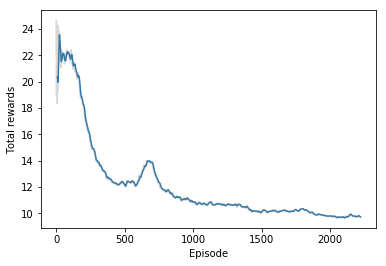

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

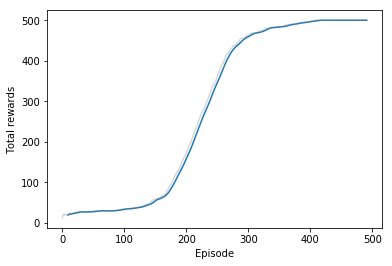

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

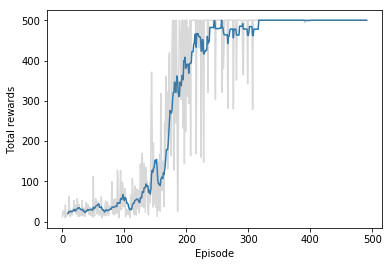

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.